<a href="https://colab.research.google.com/github/geese-kim/CS492-MLCV-CW2/blob/cgan/mnist_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
# from tensorboardX import SummaryWriter

In [93]:
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

In [22]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [25]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [26]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [27]:
# writer = SummaryWriter()

In [28]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [29]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [31]:
# num_epochs = 50
num_epochs = 50
n_critic = 5
display_step = 50
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    # print('Starting epoch {}...'.format(epoch), end=' ')
    sum_d = 0
    sum_g = 0
    cnt = 0
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        # writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, step)  
        # print('g_loss:', g_loss, 'd_loss:', d_loss)
        sum_d += d_loss
        sum_g += g_loss
        cnt += 1
        
        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            # writer.add_image('sample_image', grid, step)
    print('Done!')
    sum_d /= cnt
    sum_g /= cnt
    d_losses.append(sum_d)
    g_losses.append(sum_g)
    print("[{:d}] d_loss: {:f} g_loss: {:f}".format(epoch, sum_d, sum_g))

Done!
[0] d_loss: 0.834289 g_loss: 2.123682
Done!
[1] d_loss: 0.332171 g_loss: 3.970412
Done!
[2] d_loss: 0.430021 g_loss: 3.558453
Done!
[3] d_loss: 0.458134 g_loss: 3.245062
Done!
[4] d_loss: 0.577253 g_loss: 2.695605
Done!
[5] d_loss: 0.596467 g_loss: 2.507970
Done!
[6] d_loss: 0.715202 g_loss: 2.129014
Done!
[7] d_loss: 0.745293 g_loss: 2.019625
Done!
[8] d_loss: 0.798573 g_loss: 1.891410
Done!
[9] d_loss: 0.827751 g_loss: 1.811845
Done!
[10] d_loss: 0.857915 g_loss: 1.730302
Done!
[11] d_loss: 0.891994 g_loss: 1.652048
Done!
[12] d_loss: 0.951323 g_loss: 1.522079
Done!
[13] d_loss: 1.000477 g_loss: 1.412423
Done!
[14] d_loss: 1.028837 g_loss: 1.363923
Done!
[15] d_loss: 1.052370 g_loss: 1.312567
Done!
[16] d_loss: 1.067836 g_loss: 1.276360
Done!
[17] d_loss: 1.109341 g_loss: 1.197929
Done!
[18] d_loss: 1.116878 g_loss: 1.175897
Done!
[19] d_loss: 1.124015 g_loss: 1.164927
Done!
[20] d_loss: 1.150735 g_loss: 1.108990
Done!
[21] d_loss: 1.166243 g_loss: 1.080542
Done!
[22] d_loss: 1

In [32]:
torch.save(generator.state_dict(), 'generator_state_b{:d}_e{:d}.pt'.format(batch_size, num_epochs))

In [33]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [34]:
images = generator(z, labels).unsqueeze(1)

In [35]:
grid = make_grid(images, nrow=10, normalize=True)

TypeError: ignored

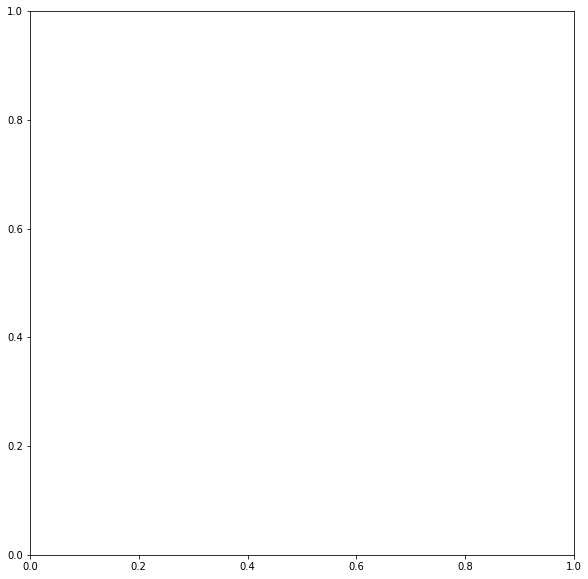

In [36]:
# fig, ax = plt.subplots(figsize=(10,10))
# # ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
# ax.imshow(grid.data, cmap='binary')
# ax.axis('off')

In [30]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

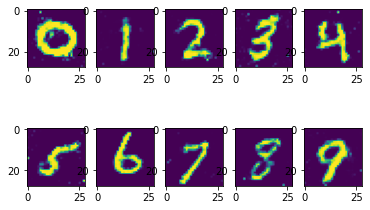

In [43]:
fig,ax = plt.subplots(2,5)

for i in range(10):
        image = generate_digit(generator, i)
        ax[i//5][i%5].imshow(image)
fig.show()

In [100]:
def generate_digit2(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return img.flatten()

data_3 = torch.zeros((6000, 784), dtype=torch.float32)
for i in range(10):
  for j in range(600):
    data_3[600*i+j, :] = generate_digit2(generator, i)


In [103]:
data_3.size()

torch.Size([6000, 784])

In [116]:
model = torch.load("model_saved.model")
net = model['lenet']
data = data_3.reshape((6000, 28, 28)).float()
# data = transforms.ToPILImage()(data)
transform = transforms.Compose([
        # Pad images with 0s
        transforms.Pad((0,4,4,0), fill=0, padding_mode='constant'),
    
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
img = transforms.ToPILImage()(data[0])
output = net(img.transform())


TypeError: ignored